In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare ElasticSearch server for Colab

In [1]:
%%bash

wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512
tar -xzf elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
chown -R daemon:daemon ./elasticsearch-7.9.2/
shasum -a 512 -c elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512

elasticsearch-oss-7.9.2-linux-x86_64.tar.gz: OK


In [2]:
%%bash
chown -R daemon:daemon ./elasticsearch-7.9.2/
shasum -a 512 -c elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512

elasticsearch-oss-7.9.2-linux-x86_64.tar.gz: OK


In [ ]:
%%bash --bg

daemon elasticsearch-7.9.2/bin/elasticsearch

# Pip installs

In [ ]:
! pip install -q vllm triton beir FlagEmbedding

# Define Bier dataset loading, BM25 search, and reranker execution

In [1]:
from beir import util
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval
from beir.retrieval.search.lexical import BM25Search as BM25
from beir.reranking.models import CrossEncoder
from beir.reranking import Rerank
import os
from typing import List, Dict, Tuple

def prep_bier_data(dataset_name):
    print(dataset_name+ "\n")
    out_dir = os.path.join("/content/drive/MyDrive/", "bier_datasets")

    if "/" in dataset_name:
        data_path = os.path.join(out_dir, dataset_name)
    else:
        #### Download trec-covid.zip dataset and unzip the dataset
        url = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset_name)
        try:
            data_path = util.download_and_unzip(url, out_dir)
        except:
            raise dataset_name

    #### Provide the data path where trec-covid has been downloaded and unzipped to the data loader
    # data folder would contain these files:
    # (1) trec-covid/corpus.jsonl  (format: jsonlines)
    # (2) trec-covid/queries.jsonl (format: jsonlines)
    # (3) trec-covid/qrels/test.tsv (format: tsv ("\t"))
    return GenericDataLoader(data_path).load(split="test")


def get_bm_25_results_retriever(dataset_name, corpus, queries):
    #########################################
    #### (1) RETRIEVE Top-100 docs using BM25
    #########################################

    #### Provide parameters for Elasticsearch
    hostname = "localhost" #localhost
    index_name = dataset_name.replace("/", "__")
    initialize = True # False

    language = "cjk" if any([x in dataset_name for x in ["chinese", "japanese", "korean"]]) else "english"
    model = BM25(index_name=index_name, hostname=hostname, initialize=initialize, language=language)
    retriever = EvaluateRetrieval(model)

    #### Retrieve dense results (format of results is identical to qrels)
    results = retriever.retrieve(corpus, queries)

    return results, retriever

def get_cross_encoder_results(cross_encoder_model, corpus, queries, qrels, results, retriever):
    ################################################
    #### (2) RERANK Top-100 docs using Cross-Encoder
    ################################################
    reranker = Rerank(cross_encoder_model, batch_size=128)

    print(len(queries))
    # Rerank top-100 results using the reranker provided
    rerank_results = reranker.rerank(corpus, queries, results, top_k=100)

    #### Evaluate your retrieval using NDCG@k, MAP@K ...
    return EvaluateRetrieval.evaluate(qrels, rerank_results, retriever.k_values)

/root/miniconda3/envs/vllm/lib/python3.10/site-packages/beir/util.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Define custom reranker functions

In [2]:
from FlagEmbedding import FlagReranker

class FlagEmbeddingCrossEncoder:
    def __init__(self, model_name: str, **kwargs):
        self.reranker = FlagReranker(model_name, use_fp16=True)

    def predict(self, sentences: List[Tuple[str,str]], batch_size: int = 32, show_progress_bar: bool = True) -> List[float]:
        return self.reranker.compute_score(sentences, batch_size=batch_size)

In [3]:
from vllm import LLM, SamplingParams
import numpy as np

class LBCrossEncoder:
    def __init__(self, model_path: str, **kwargs):
        self.llm = LLM(model=model_path, gpu_memory_utilization=0.3)
        self.sampling_params = SamplingParams(temperature=0.0, logprobs=14, max_tokens=1)
        self.tok = self.llm.llm_engine.tokenizer.tokenizer
        self.idx_tokens = [self.tok.encode(str(i))[0] for i in range(1, 8)]

    def make_reranker_input(self, t, q):
        return f"<<<Query>>>\n{q}\n\n<<<Context>>>\n{t}"

    def make_reranker_training_datum(self, context, question):
        system_message = "Given a query and a piece of text, output a score of 1-7 based on how related the query is to the text. 1 means least related and 7 is most related."

        return [
            {"role": "system", "content": system_message},
            {"role": "user", "content": self.make_reranker_input(context, question)},
        ]

    def get_prob(self, logprob_dict, tok_id):
        return np.exp(logprob_dict[tok_id].logprob) if tok_id in logprob_dict.keys() else 0

    def predict(self, sentences: List[Tuple[str,str]], batch_size: int = 32, show_progress_bar: bool = True) -> List[float]:
        chats = [self.make_reranker_training_datum(c, q) for q, c in sentences]
        responses = self.llm.chat(chats, self.sampling_params)
        probs = np.array([[self.get_prob(r.outputs[0].logprobs[0], y) for y in self.idx_tokens] for r in responses])
        scores = probs[:, 3:].mean(axis=1) - probs[:, :4].mean(axis=1)
        return scores

In [4]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from tqdm.auto import trange

class AlibabaCrossEncoder:
    def __init__(self, model_path: str, **kwargs):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_path, trust_remote_code=True,
            torch_dtype=torch.float16
        ).to(torch.device("cuda"))
        self.model.eval()

    def predict(self, sentences: List[Tuple[str,str]], batch_size: int = 32, show_progress_bar: bool = True) -> List[float]:
        range_fn = trange if show_progress_bar else range
        scores = []
        with torch.no_grad():
            for i in range_fn(0, len(sentences), batch_size):
                inputs = self.tokenizer(sentences[i:i+batch_size], padding=True, truncation=True, return_tensors='pt', max_length=512).to(torch.device("cuda"))
                scores.extend(self.model(**inputs, return_dict=True).logits.view(-1, ).cpu().numpy().tolist())
        return scores

# Download and process all datasets in parallel to save time

In [ ]:
# from multiprocessing import Pool

# dataset_names = ['arguana', 'dbpedia-entity', 'fiqa', 'nfcorpus', 'scidocs', 'scifact', 'trec-covid-v2', 'vihealthqa', 'webis-touche2020']

# with Pool(len(dataset_names)) as p:
#     print(dataset_names)
#     p.map(prep_bier_data, dataset_names)

fiqanfcorpusarguanadbpedia-entityscifactvihealthqawebis-touche2020scidocstrec-covid-v2



















  0%|          | 0/3633 [00:00<?, ?it/s]

  0%|          | 0/9896 [00:00<?, ?it/s]

  0%|          | 0/5183 [00:00<?, ?it/s]

  0%|          | 0/8674 [00:00<?, ?it/s]

  0%|          | 0/57638 [00:00<?, ?it/s]

['arguana', 'dbpedia-entity', 'fiqa', 'nfcorpus', 'scidocs', 'scifact', 'trec-covid-v2', 'vihealthqa', 'webis-touche2020']


  0%|          | 0/129179 [00:00<?, ?it/s]

  0%|          | 0/25657 [00:00<?, ?it/s]

  0%|          | 0/382545 [00:00<?, ?it/s]

BadZipFile: File is not a zip file

# Load models to test

In [5]:
flagemb_ce, flagemb_name = FlagEmbeddingCrossEncoder("BAAI/bge-reranker-v2-m3"), "BAAI/bge-reranker-v2-m3"
lightbl_ce, lightbl_name = LBCrossEncoder("/cache/models/target_neurons_10R_reranker/results/target_neurons/checkpoint-285430"), "lightblue/reranker_0.5_cont_filt_7max"
sentemb_ce, sentemb_name = CrossEncoder("cross-encoder/ms-marco-electra-base"), "cross-encoder/ms-marco-electra-base"
alibaba_ce, alibaba_name = AlibabaCrossEncoder("Alibaba-NLP/gte-multilingual-reranker-base"), "Alibaba-NLP/gte-multilingual-reranker-base"

models = [
    # (flagemb_ce, flagemb_name),
    (lightbl_ce, lightbl_name),
    # (sentemb_ce, sentemb_name),
    # (alibaba_ce, alibaba_name)
]

# models.append((
#     ParallelCrossEncoders([flagemb_ce, lightbl_ce]),
#     "lb_plus_bge"
# ))

INFO 02-26 12:34:59 __init__.py:207] Automatically detected platform cuda.
INFO 02-26 12:35:07 config.py:549] This model supports multiple tasks: {'generate', 'reward', 'score', 'embed', 'classify'}. Defaulting to 'generate'.
INFO 02-26 12:35:07 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='/cache/models/target_neurons_10R_reranker/results/target_neurons/checkpoint-285430', speculative_config=None, tokenizer='/cache/models/target_neurons_10R_reranker/results/target_neurons/checkpoint-285430', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_conf

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 02-26 12:35:10 model_runner.py:1115] Loading model weights took 0.9277 GB
INFO 02-26 12:35:12 worker.py:267] Memory profiling takes 1.01 seconds
INFO 02-26 12:35:12 worker.py:267] the current vLLM instance can use total_gpu_memory (23.53GiB) x gpu_memory_utilization (0.30) = 7.06GiB
INFO 02-26 12:35:12 worker.py:267] model weights take 0.93GiB; non_torch_memory takes 0.08GiB; PyTorch activation peak memory takes 1.44GiB; the rest of the memory reserved for KV Cache is 4.61GiB.
INFO 02-26 12:35:12 executor_base.py:111] # cuda blocks: 25196, # CPU blocks: 21845
INFO 02-26 12:35:12 executor_base.py:116] Maximum concurrency for 32768 tokens per request: 12.30x
INFO 02-26 12:35:16 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_ut

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:20<00:00,  1.71it/s]

INFO 02-26 12:35:36 model_runner.py:1562] Graph capturing finished in 20 secs, took 0.19 GiB
INFO 02-26 12:35:36 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 25.69 seconds


# Run test

Only run test on first 100 queries of each dataset to save computation time of rerankers

In [6]:
import pandas as pd
import time

dataset_names = [
    'arguana',
    'dbpedia-entity',
    'fiqa',
    'nfcorpus',
    'scidocs', 'scifact', 'trec-covid-v2', 'vihealthqa', 'webis-touche2020'
    ]

for dataset_name in dataset_names:
    print(dataset_name)

    corpus, queries, qrels = prep_bier_data(dataset_name)

    # Select first 250 queries, sorted by query key, to save computation time
    queries = {x: queries[x] for x in sorted(queries.keys())[:250]}
    results, retriever = get_bm_25_results_retriever(dataset_name, corpus, queries)

    for cross_encoder_model, model_name in models:
        print(model_name)

        t0 = time.time()
        ndcg, _map, recall, precision = get_cross_encoder_results(cross_encoder_model, corpus, queries, qrels, results, retriever)
        time_elapsed = time.time() - t0

        save_dir = f"./bier_results/" + model_name.replace("/", "__")

        !mkdir -p $save_dir

        save_path = f"{save_dir}/" + dataset_name.replace("/", "__") + ".parquet"

        pd.DataFrame(
            dict(**ndcg, **_map, **recall, **precision, time=time_elapsed),
            index=[[dataset_name, model_name]]
        ).to_parquet(save_path)

arguana
arguana



  0%|          | 0/8674 [00:00<?, ?it/s]

que: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


lightblue/reranker_0.5_cont_filt_7max
250
INFO 02-26 12:35:57 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


Processed prompts: 100%|██████████| 25000/25000 [01:46<00:00, 235.36it/s, est. speed input: 141870.48 toks/s, output: 235.36 toks/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


dbpedia-entity
dbpedia-entity



  0%|          | 0/4635922 [00:00<?, ?it/s]

que: 100%|██████████| 2/2 [00:06<00:00,  3.47s/it]


lightblue/reranker_0.5_cont_filt_7max
250


Processed prompts: 100%|██████████| 25000/25000 [00:30<00:00, 813.91it/s, est. speed input: 119101.00 toks/s, output: 813.91 toks/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


fiqa
fiqa



  0%|          | 0/57638 [00:00<?, ?it/s]

que: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


lightblue/reranker_0.5_cont_filt_7max
250


Processed prompts: 100%|██████████| 25000/25000 [00:59<00:00, 419.07it/s, est. speed input: 134725.20 toks/s, output: 419.07 toks/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


nfcorpus
nfcorpus



  0%|          | 0/3633 [00:00<?, ?it/s]

que: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


lightblue/reranker_0.5_cont_filt_7max
250


Processed prompts: 100%|██████████| 17555/17555 [00:53<00:00, 326.09it/s, est. speed input: 138128.98 toks/s, output: 326.09 toks/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


scidocs
scidocs



  0%|          | 0/25657 [00:00<?, ?it/s]

que: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


lightblue/reranker_0.5_cont_filt_7max
250


Processed prompts: 100%|██████████| 25000/25000 [00:55<00:00, 447.30it/s, est. speed input: 136016.57 toks/s, output: 447.30 toks/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


scifact
scifact



  0%|          | 0/5183 [00:00<?, ?it/s]

que: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


lightblue/reranker_0.5_cont_filt_7max
250


Processed prompts: 100%|██████████| 24966/24966 [01:17<00:00, 321.72it/s, est. speed input: 139205.89 toks/s, output: 321.72 toks/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


trec-covid-v2
trec-covid-v2



  0%|          | 0/129179 [00:00<?, ?it/s]

que: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


lightblue/reranker_0.5_cont_filt_7max
50


Processed prompts: 100%|██████████| 5000/5000 [00:14<00:00, 356.73it/s, est. speed input: 136375.40 toks/s, output: 356.74 toks/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


vihealthqa
vihealthqa



  0%|          | 0/9896 [00:00<?, ?it/s]

que: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


lightblue/reranker_0.5_cont_filt_7max
250


Processed prompts: 100%|██████████| 25000/25000 [00:54<00:00, 460.12it/s, est. speed input: 132252.61 toks/s, output: 460.12 toks/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


webis-touche2020
webis-touche2020



  0%|          | 0/382545 [00:00<?, ?it/s]

que: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]


lightblue/reranker_0.5_cont_filt_7max
49


Processed prompts: 100%|██████████| 4900/4900 [00:21<00:00, 225.84it/s, est. speed input: 142902.23 toks/s, output: 225.84 toks/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [7]:
from glob import glob
import pandas as pd
from tqdm.auto import tqdm

paths = glob("./bier_results/**/*.parquet")

df_list = []

for p in tqdm(paths):
    single_df = pd.read_parquet(p)
    df_list.append(pd.DataFrame(single_df.iloc[0].to_dict(),
             index=[(single_df.index[0], single_df.index[1])]
             ))

  0%|          | 0/36 [00:00<?, ?it/s]

In [8]:
all_df = pd.concat(df_list).reset_index(drop=False)

In [9]:
all_df["dataset_name"] = all_df["index"].str[0]
all_df["model_name"] = all_df["index"].str[1]
all_df["model_name"] = all_df["model_name"].apply(lambda x: x.replace("lightblue/reranker_0.5_cont_filt_7max", "lightblue/lb-reranker-v1.0"))

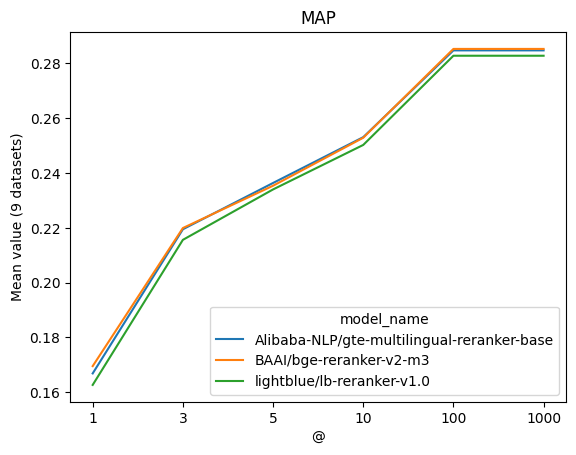

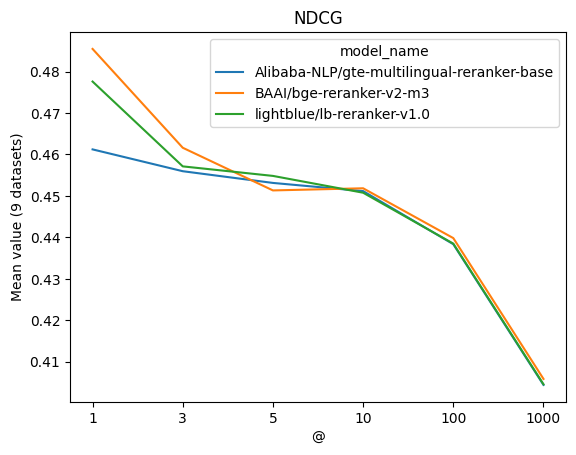

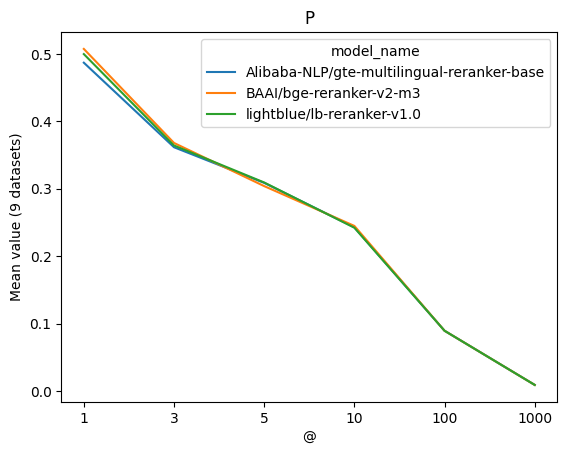

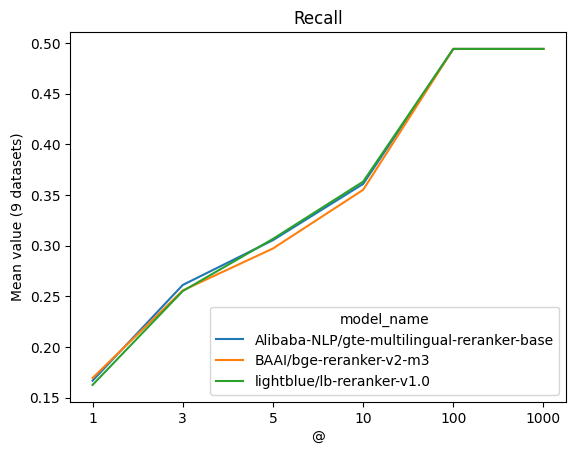

In [10]:
metric_names = ['MAP', 'NDCG', 'P', 'Recall']
metrics_k_list = [1, 3, 5, 10, 100, 1000]

for metric_name in metric_names:
    grouped = all_df[
        (all_df["model_name"] != "cross-encoder/ms-marco-electra-base") # Remove this because the results outlie so much lower that they detract from the graph
    ].rename(
        columns={f"{metric_name}@{k}": k for k in metrics_k_list}
    ).groupby("model_name")[metrics_k_list].agg(['mean', 'std'])

    # Extract mean and standard deviation
    means = grouped.T.loc[[x[1] == "mean" for x in grouped.T.index]].reset_index(level=1, drop=True)
    std = grouped.T.loc[[x[1] == "std" for x in grouped.T.index]].reset_index(level=1, drop=True)

    # Plot with error bars
    ax = means.plot(title=metric_name)

    ax.set_xlabel("@")
    ax.set_ylabel("Mean value (9 datasets)")

Text(0.5, 0.98, '')

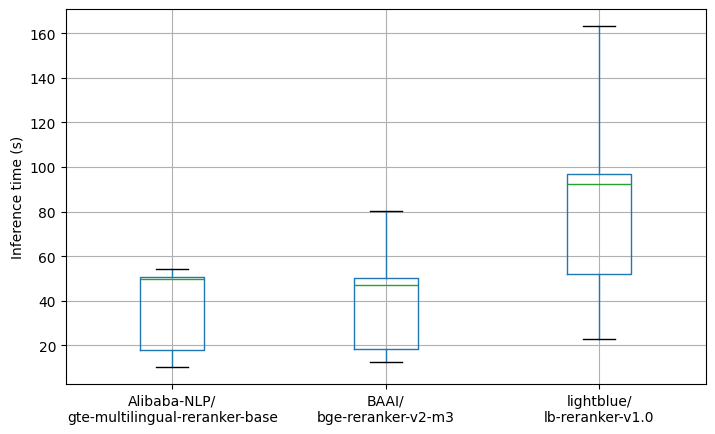

In [11]:
all_df["Model name"] = all_df["model_name"].apply(lambda x: x.replace("/", "/\n"))
ax = all_df[
        (all_df["model_name"] != "cross-encoder/ms-marco-electra-base") # Remove this because the results outlie so much lower that they detract from the graph
    ].boxplot(column="time", by="Model name", figsize=(8, 5))
ax.set_ylabel("Inference time (s)")
ax.set_xlabel("")
ax.set_title("")
ax.figure.suptitle("")

In [12]:
metric_names = ['MAP', 'NDCG', 'P', 'Recall']
metrics_k_list = [1, 3, 5, 10, 100, 1000]

all_df[["dataset_name", "model_name"] + [f"MAP@{k}" for k in metrics_k_list]]

,dataset_name,model_name,MAP@1,MAP@3,MAP@5,MAP@10,MAP@100,MAP@1000
0,arguana,BAAI/bge-reranker-v2-m3,0.25200,0.35467,0.38647,0.40391,0.41608,0.41608
1,dbpedia-entity,BAAI/bge-reranker-v2-m3,0.05952,0.10140,0.11931,0.14972,0.20320,0.20320
2,fiqa,BAAI/bge-reranker-v2-m3,0.23052,0.32733,0.35081,0.36176,0.37075,0.37075
3,nfcorpus,BAAI/bge-reranker-v2-m3,0.05669,0.09943,0.11191,0.12754,0.15261,0.15261
4,scidocs,BAAI/bge-reranker-v2-m3,0.03320,0.06683,0.07858,0.09125,0.10666,0.10666
5,scifact,BAAI/bge-reranker-v2-m3,0.60733,0.67249,0.68289,0.69549,0.69991,0.69991
6,trec-covid-v2,BAAI/bge-reranker-v2-m3,0.00285,0.00818,0.01285,0.02449,0.11505,0.11505
7,vihealthqa,BAAI/bge-reranker-v2-m3,0.24200,0.26278,0.26788,0.27184,0.27288,0.27288
8,webis-touche2020,BAAI/bge-reranker-v2-m3,0.04175,0.08631,0.10777,0.15004,0.23068,0.23068
9,arguana,lightblue/lb-reranker-v1.0,0.26000,0.38533,0.41993,0.44143,0.44956,0.44956


In [13]:
all_df[["dataset_name", "model_name"] + [f"Recall@{k}" for k in metrics_k_list]]

,dataset_name,model_name,Recall@1,Recall@3,Recall@5,Recall@10,Recall@100,Recall@1000
0,arguana,BAAI/bge-reranker-v2-m3,0.25200,0.48400,0.62400,0.76000,0.97200,0.97200
1,dbpedia-entity,BAAI/bge-reranker-v2-m3,0.05952,0.11294,0.14335,0.20525,0.34700,0.34700
2,fiqa,BAAI/bge-reranker-v2-m3,0.23052,0.37025,0.42147,0.46899,0.55222,0.55222
3,nfcorpus,BAAI/bge-reranker-v2-m3,0.05669,0.11000,0.13079,0.16096,0.25293,0.25293
4,scidocs,BAAI/bge-reranker-v2-m3,0.03320,0.08980,0.12140,0.17280,0.34900,0.34900
5,scifact,BAAI/bge-reranker-v2-m3,0.60733,0.74047,0.77713,0.84907,0.91187,0.91187
6,trec-covid-v2,BAAI/bge-reranker-v2-m3,0.00285,0.00832,0.01337,0.02644,0.13654,0.13654
7,vihealthqa,BAAI/bge-reranker-v2-m3,0.24200,0.28733,0.30933,0.33933,0.36333,0.36333
8,webis-touche2020,BAAI/bge-reranker-v2-m3,0.04175,0.09940,0.13375,0.21250,0.56093,0.56093
9,arguana,lightblue/lb-reranker-v1.0,0.26000,0.54000,0.69200,0.85200,0.97200,0.97200


In [14]:
all_df[["dataset_name", "model_name"] + [f"NDCG@{k}" for k in metrics_k_list]]

,dataset_name,model_name,NDCG@1,NDCG@3,NDCG@5,NDCG@10,NDCG@100,NDCG@1000
0,arguana,BAAI/bge-reranker-v2-m3,0.25200,0.38790,0.44539,0.48865,0.53860,0.53860
1,dbpedia-entity,BAAI/bge-reranker-v2-m3,0.49000,0.41968,0.38670,0.36641,0.33781,0.33375
2,fiqa,BAAI/bge-reranker-v2-m3,0.48000,0.43178,0.42871,0.43717,0.46277,0.46277
3,nfcorpus,BAAI/bge-reranker-v2-m3,0.44093,0.40852,0.37891,0.34366,0.29154,0.27800
4,scidocs,BAAI/bge-reranker-v2-m3,0.16400,0.15151,0.13208,0.16007,0.22165,0.22165
5,scifact,BAAI/bge-reranker-v2-m3,0.63200,0.69559,0.71055,0.73650,0.75204,0.75204
6,trec-covid-v2,BAAI/bge-reranker-v2-m3,0.90000,0.87520,0.84588,0.82059,0.51527,0.22713
7,vihealthqa,BAAI/bge-reranker-v2-m3,0.50000,0.33350,0.34469,0.35654,0.36281,0.36281
8,webis-touche2020,BAAI/bge-reranker-v2-m3,0.51020,0.45088,0.38902,0.35698,0.47593,0.47593
9,arguana,lightblue/lb-reranker-v1.0,0.26000,0.42514,0.48762,0.53951,0.56954,0.56954


In [15]:
all_df[["dataset_name", "model_name"] + [f"P@{k}" for k in metrics_k_list]]

,dataset_name,model_name,P@1,P@3,P@5,P@10,P@100,P@1000
0,arguana,BAAI/bge-reranker-v2-m3,0.25200,0.16133,0.12480,0.07600,0.00972,0.00097
1,dbpedia-entity,BAAI/bge-reranker-v2-m3,0.64000,0.48667,0.41040,0.33120,0.07628,0.00763
2,fiqa,BAAI/bge-reranker-v2-m3,0.48000,0.29600,0.21120,0.11840,0.01436,0.00144
3,nfcorpus,BAAI/bge-reranker-v2-m3,0.44726,0.38537,0.32321,0.25063,0.06789,0.00679
4,scidocs,BAAI/bge-reranker-v2-m3,0.16400,0.14800,0.12000,0.08560,0.01728,0.00173
5,scifact,BAAI/bge-reranker-v2-m3,0.63200,0.26533,0.16960,0.09520,0.01028,0.00103
6,trec-covid-v2,BAAI/bge-reranker-v2-m3,0.92000,0.90667,0.88000,0.87200,0.50480,0.05048
7,vihealthqa,BAAI/bge-reranker-v2-m3,0.50000,0.19867,0.12800,0.07000,0.00748,0.00075
8,webis-touche2020,BAAI/bge-reranker-v2-m3,0.53061,0.46259,0.36735,0.30408,0.09531,0.00953
9,arguana,lightblue/lb-reranker-v1.0,0.26000,0.18000,0.13840,0.08520,0.00972,0.00097
